In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from os import listdir

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [3]:
imlist = sorted(listdir('../data/'))
file = imlist[0]
image = cv2.imread('../data/' + file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

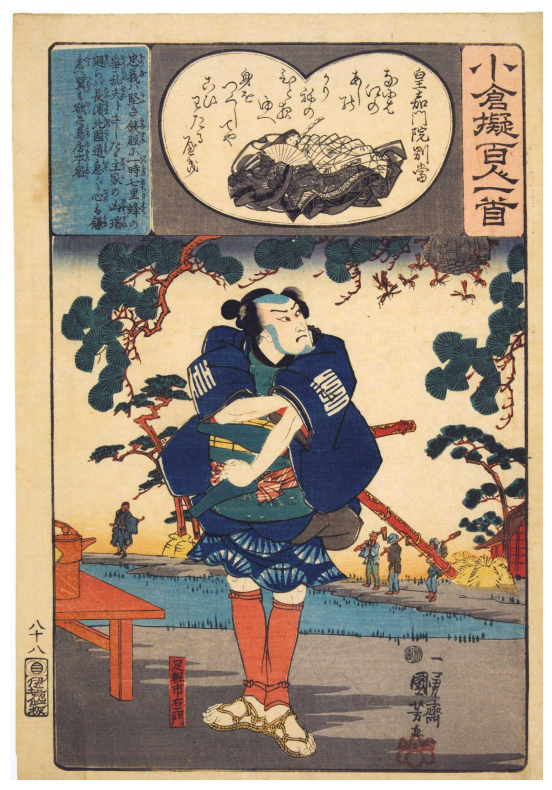

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [9]:
print(len(masks))
print(masks[0].keys())

83
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [6]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=10, #32
    pred_iou_thresh=0.86, #0.86
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=10,  # Requires open-cv to run post-processing #100
)

In [7]:
masks2 = mask_generator_2.generate(image)

In [8]:
len(masks2)

64

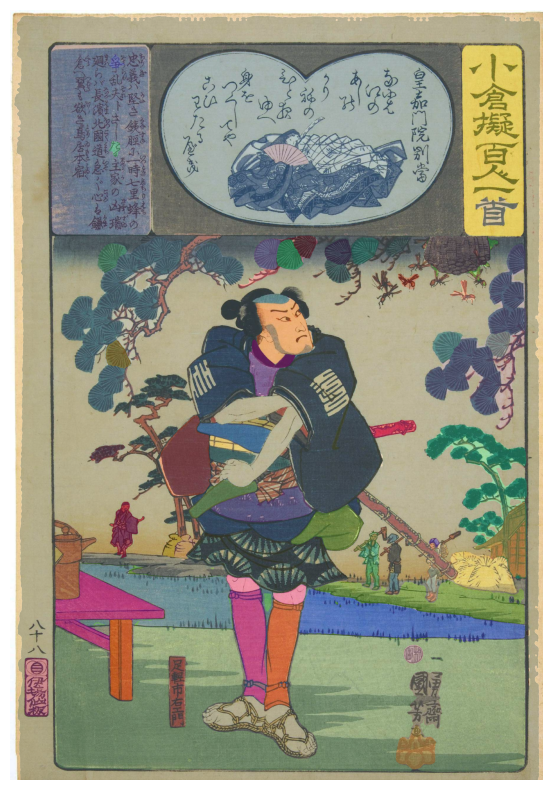

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


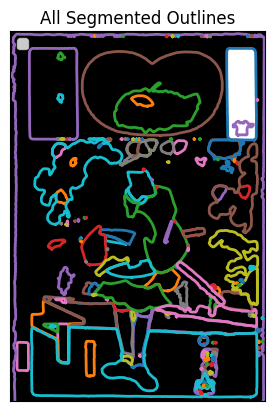

In [14]:
segmented_images = [m['segmentation'] for m in masks2]

# Create a new figure for the combined plot
fig, ax = plt.subplots()

# Loop through each segmented image in the list
for i, segmented_image in enumerate(segmented_images):
    # Find contours at a constant value of 0.5
    contours = measure.find_contours(segmented_image, 0.5)
    
    # Plot the contours on the same plot
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

# Assuming all images have the same size
ax.imshow(segmented_images[0], cmap=plt.cm.gray)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.title('All Segmented Outlines')
plt.legend()
plt.show()